<a href="https://colab.research.google.com/github/wiendewani/Praktikum_ML/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Data

gak perlu di run lagi

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vitaminc/cigarette-smoker-detection

100% 2.50G/2.50G [00:34<00:00, 50.7MB/s]
100% 2.50G/2.50G [00:34<00:00, 78.2MB/s]


In [ ]:
import os
import zipfile

In [ ]:
local_zip = '/content/cigarette-smoker-detection.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Pembelajaran Mesin/Project ML')
zip_ref.close()

In [14]:
!pip install split-folders

In [15]:
!mkdir "/content/drive/MyDrive/Pembelajaran Mesin/Project ML/dataset"

In [16]:
import splitfolders

splitfolders.ratio("/content/drive/MyDrive/Pembelajaran Mesin/Project ML/data/data", output="/content/drive/MyDrive/Pembelajaran Mesin/Project ML/dataset", seed= 1337, ratio =(.8,.2), group_prefix=None)

Copying files: 3275 files [01:39, 32.80 files/s]


## Import Library

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

##Load Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [8]:
print(len(os.listdir('/content/drive/MyDrive/Pembelajaran Mesin/Project ML/data/data/not_smoking')))
print(len(os.listdir('/content/drive/MyDrive/Pembelajaran Mesin/Project ML/data/data/smoking')))

1279
1996


In [17]:

base_dir = '/content/drive/MyDrive/Pembelajaran Mesin/Project ML/dataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

train_Not_Smoking_dir = os.path.join(train_dir, 'not_smoking')
train_Smoking_dir = os.path.join(train_dir, 'smoking')

validation_Not_Smoking_dir = os.path.join(validation_dir, 'not_smoking')
validation_Smoking_dir = os.path.join(validation_dir, 'smoking')

In [18]:
# Cek jumlah data train dan data validation
print('total training Not Smoking images:', len(os.listdir(train_Not_Smoking_dir)))
print('total training Smoking images:', len(os.listdir(train_Smoking_dir)))
print('total validation Not Smoking images:', len(os.listdir(validation_Not_Smoking_dir)))
print('total validation Smoking images:', len(os.listdir(validation_Smoking_dir)))

total training Not Smoking images: 1023
total training Smoking images: 1596
total validation Not Smoking images: 256
total validation Smoking images: 400


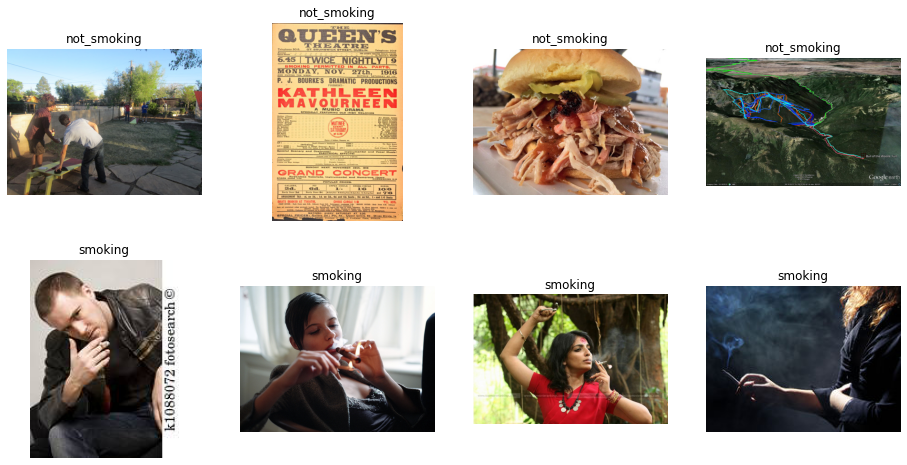

In [19]:
# Tampilkan 8 image per kelas dengan ukuran 4x4 

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 2
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_Not_Smoking_dir, fname) 
                for fname in os.listdir(train_Not_Smoking_dir)[pic_index-4:pic_index]]
next_dog_pix = [os.path.join(train_Smoking_dir, fname) 
                for fname in os.listdir(train_Smoking_dir)[pic_index-4:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  if i == nrows * ncols:
    break
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  sp.set_title(os.path.basename(os.path.dirname(img_path)))

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
# for file in os.listdir(train_Not_Smoking_dir): 
#     if file.endswith(".jpg"): 
#         img = Image.open(file)
#         file_name, file_ext = os.path.splitext(file)
#         img.save('/png/{}.png'.format(file_name))

In [20]:
count = 0
for item in os.listdir(train_Not_Smoking_dir):
  os.rename(base_dir + "/train/not_smoking/" + item, base_dir + "/train/not_smoking/" + str(count) + "_not_smoking_train" +".png")
  count += 1

count = 0
for item in os.listdir(train_Smoking_dir):
  os.rename(base_dir + "/train/smoking/" + item, base_dir + "/train/smoking/" + str(count) + "_smoking_train" +".png")
  count += 1

count = 0
for item in os.listdir(validation_Not_Smoking_dir):
  os.rename(base_dir + "/val/not_smoking/" + item, base_dir + "/val/not_smoking/" + str(count) + "_not_smoking_test" +".png")
  count += 1

count = 0
for item in os.listdir(validation_Smoking_dir):
  os.rename(base_dir + "/val/smoking/" + item, base_dir + "/val/smoking/" + str(count) + "_smoking_test" +".png")
  count += 1

In [23]:
# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)


In [24]:
# Gather data validation
val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
       if ".png" in file:
            imagePath = os.path.join(r, file)
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [25]:
# Tampilkan shape dari data train dan data validation
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (2619, 224, 224, 3)
Train Label =  (2619,)
Validation Data =  (656, 224, 224, 3)
Validation Label =  (656,)


In [28]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", train_data[45][45][45])

x_train = train_data.astype('float32') / 255.0
x_test = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[45][45][45])

Data sebelum di-normalisasi  [0.9372549  0.88235295 0.81960785]
Data setelah di-normalisasi  [0.00367551 0.00346021 0.00321415]


In [30]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label)

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(val_label)

print("Label setelah di-encoder ", y_train)

Label sebelum di-encoder  ['not_smoking' 'not_smoking' 'not_smoking' ... 'smoking' 'smoking'
 'smoking']
Label setelah di-encoder  [0 0 0 ... 1 1 1]
